In [45]:
# import libraries
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [72]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 8
epochs = 20
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets and prepare dataloaders

  # MNIST

train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

train_loader_MNIST = DataLoader(train_data, batch_size=batch_size,
                                num_workers=num_workers)
test_loader_MNIST = DataLoader(test_data, batch_size=batch_size, 
                               num_workers=num_workers)

  # CIFAR 10

batch_size = 16

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(root='data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                              download=True, transform=transform)

train_loader_CIFAR10 = DataLoader(train_data, batch_size=batch_size,
                                  num_workers=num_workers)
test_loader_CIFAR10 = DataLoader(test_data, batch_size=batch_size,
                                 num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
class Net(nn.Module):
    def __init__(self, data='MNIST'):
        super(Net, self).__init__()

        self.h = 28 if data is 'MNIST' else 32
        self.c = 1 if data is 'MNIST' else 3

        self.conv1 = nn.Conv2d(self.c,4,5)    #             h x h x c   -->   (h-4) x (h-4) x 4
        self.maxpool = nn.MaxPool2d(2,2)      #     (h-4) x (h-4) x 4   -->   (h-4)/2 x (h-4)/2 x 4
        self.conv2 = nn.Conv2d(4,8,3)         # (h-4)/2 x (h-4)/2 x 4   -->   (h-8)/2 x (h-8)/2 x 8

        self.fc1 = nn.Linear((self.h-8)**2 // 2, 128)   # (h-8)^2 * 2   -->   512
        self.fc2 = nn.Linear(128, 10)         #                   512   -->   10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool(x)

        # Flatten
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

In [67]:
model = Net(data='MNIST').to(device)
print(model, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Net(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
) cuda:0


In [68]:
training_loss1 = []
test_acc1 = []

for epoch in range(epochs):
    # monitor training loss
    train_loss = 0.0
    total_correct = 0
    total = 0
    
    model.train()       # Training mode

    # Training loop
    for data, target in tqdm(train_loader_MNIST):

        optimizer.zero_grad()
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader_MNIST.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

    model.eval() # prep model for *evaluation*

    for data, target in test_loader_MNIST:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        total_correct += sum(correct)
        total += len(correct)

    print('Test Accuracy (Overall): %2.4f' % (total_correct/total))
    training_loss1.append(train_loss)
    test_acc1.append(total_correct/total)

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.070523
Test Accuracy (Overall): 0.6853


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.577907
Test Accuracy (Overall): 0.7878


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.529118
Test Accuracy (Overall): 0.7905


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.353950
Test Accuracy (Overall): 0.9803


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.056327
Test Accuracy (Overall): 0.9788


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.044744
Test Accuracy (Overall): 0.9834


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.037793
Test Accuracy (Overall): 0.9834


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.032405
Test Accuracy (Overall): 0.9844


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.028449
Test Accuracy (Overall): 0.9848


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.024784
Test Accuracy (Overall): 0.9855


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.021979
Test Accuracy (Overall): 0.9858


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.018948
Test Accuracy (Overall): 0.9853


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.016943
Test Accuracy (Overall): 0.9856


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.014925
Test Accuracy (Overall): 0.9851


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.013311
Test Accuracy (Overall): 0.9851


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.011484
Test Accuracy (Overall): 0.9857


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.010269
Test Accuracy (Overall): 0.9857


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.009832
Test Accuracy (Overall): 0.9849


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.009928
Test Accuracy (Overall): 0.9845


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.011055
Test Accuracy (Overall): 0.9861


In [73]:
model = Net(data='CIFAR10').to(device)
print(model, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

Net(
  (conv1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
) cuda:0


In [74]:
training_loss2 = []
test_acc2 = []

for epoch in range(epochs):
    # monitor training loss
    train_loss = 0.0
    total_correct = 0
    total = 0
    
    if epoch > 5:
        for g in optimizer.param_groups

    model.train()       # Training mode

    # Training loop
    for data, target in tqdm(train_loader_CIFAR10):

        optimizer.zero_grad()
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader_CIFAR10.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

    model.eval() # prep model for *evaluation*

    for data, target in test_loader_CIFAR10:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        total_correct += sum(correct)
        total += len(correct)

    print('Test Accuracy (Overall): %2.4f' % (total_correct/total))
    training_loss2.append(train_loss)
    test_acc2.append(total_correct/total)

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.758192
Test Accuracy (Overall): 0.4539


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.409871
Test Accuracy (Overall): 0.5192


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.296359
Test Accuracy (Overall): 0.5384


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.222145
Test Accuracy (Overall): 0.5430


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.169299
Test Accuracy (Overall): 0.5442


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.126457
Test Accuracy (Overall): 0.5463


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.091356
Test Accuracy (Overall): 0.5419


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.064674
Test Accuracy (Overall): 0.5393


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.040127
Test Accuracy (Overall): 0.5254


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.017927
Test Accuracy (Overall): 0.5306


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 1.004938
Test Accuracy (Overall): 0.5120


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.983553
Test Accuracy (Overall): 0.5167


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.970387
Test Accuracy (Overall): 0.5176


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.964242
Test Accuracy (Overall): 0.5026


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.955328
Test Accuracy (Overall): 0.5057


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.947146
Test Accuracy (Overall): 0.5167


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.938916
Test Accuracy (Overall): 0.5206


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.930233
Test Accuracy (Overall): 0.5276


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.923000
Test Accuracy (Overall): 0.5310


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.918347
Test Accuracy (Overall): 0.5220


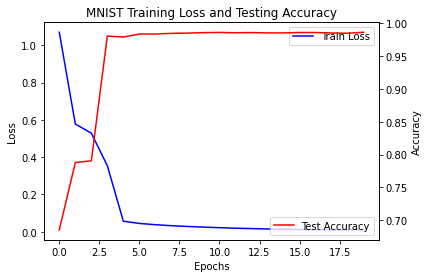

In [69]:
# Plot generation for training MNIST

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(training_loss1, color='blue')
ax_right.plot(test_acc1, color='red')
ax_left.set_xlabel('Epochs')
ax_left.set_ylabel('Loss')
ax_right.set_ylabel('Accuracy')
ax_left.legend(['Train Loss'], loc='best')
ax_right.legend(['Test Accuracy'], loc='best')
plt.title('MNIST Training Loss and Testing Accuracy')

plt.show()

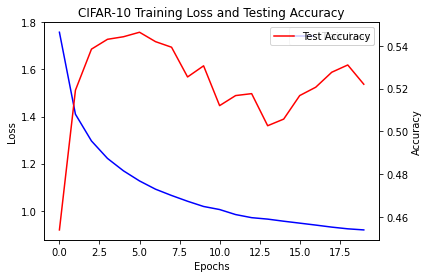

In [75]:
# Plot generation for training CIFAR-10

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(training_loss2, color='blue')
ax_right.plot(test_acc2, color='red')
ax_left.set_xlabel('Epochs')
ax_left.set_ylabel('Loss')
ax_right.set_ylabel('Accuracy')
ax_left.legend(['Train Loss'], loc='best')
ax_right.legend(['Test Accuracy'], loc='best')
plt.title('CIFAR-10 Training Loss and Testing Accuracy')

plt.show()